# 1. Introduction
We modeled survey responses regarding U.S. political groups' support for military aid to Ukraine. Three different modeling strategies were compared: separate modeling by group, pooling all groups together, and a hierarchical approach that balances group differences with shared information. Bayesian inference methods were used throughout, with Gibbs Sampling applied specifically for the hierarchical model.

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from scipy.stats import invgamma, norm
import warnings
warnings.filterwarnings('ignore')


In [7]:
data = {
    'Inc. Aid': [35, 19, 10],
    'Maintain Aid': [39, 23, 24],
    'Not Sure': [16, 26, 21],
    'Dec. Aid': [10, 33, 45]
}

index = ['Democrats', 'Independents', 'Republicans']

df = pd.DataFrame(data, index=index)

print(df)

              Inc. Aid  Maintain Aid  Not Sure  Dec. Aid
Democrats           35            39        16        10
Independents        19            23        26        33
Republicans         10            24        21        45


In [8]:
democrats = df.loc['Democrats'].values
independents = df.loc['Independents'].values
republicans = df.loc['Republicans'].values

## 2. Separate Models

### 2.1 Method
Each political group (Democrats, Independents, Republicans) was modeled independently using a normal distribution.

Bayesian inference was used with normal priors for group means and half-normal priors for standard deviations.

Sampling was performed using PyMC’s NUTS algorithm.

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'd_mu'}>,
       <Axes: title={'center': 'd_sigma'}>], dtype=object)

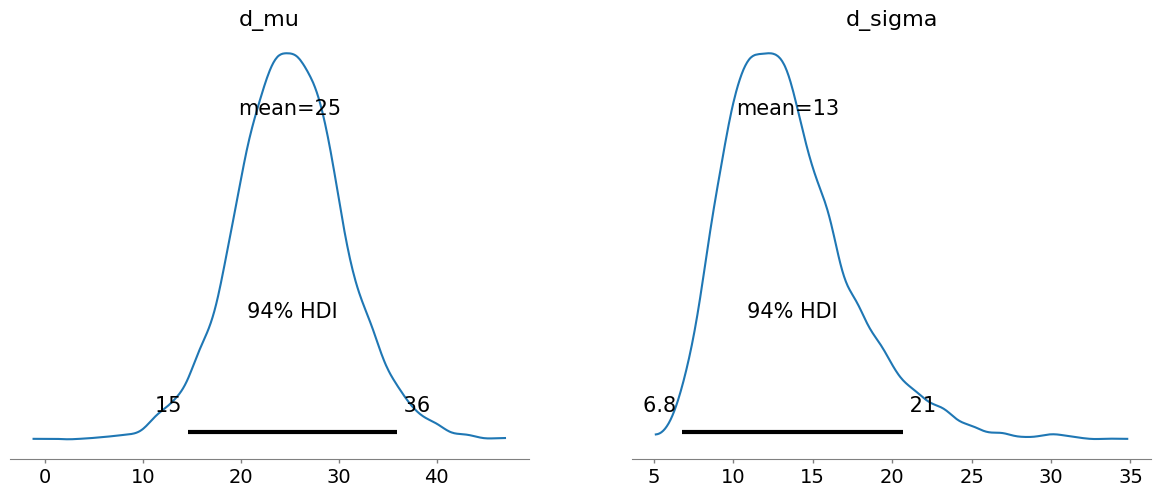

In [31]:
#democrats
with pm.Model() as d_model:
  #loose prior around 25
  mu = pm.Normal('d_mu',mu =25,sigma =10)
  sigma = pm.HalfNormal('d_sigma',sigma =10)
  observed = pm.Normal('d_observed',mu = mu,sigma =sigma,observed = democrats,shape = len(democrats))
  trace_d = pm.sample(2000,tune = 1000, return_inferencedata= True, random_seed=123)
az.plot_posterior(trace_d)


Output()

array([<Axes: title={'center': 'r_mu'}>,
       <Axes: title={'center': 'r_sigma'}>], dtype=object)

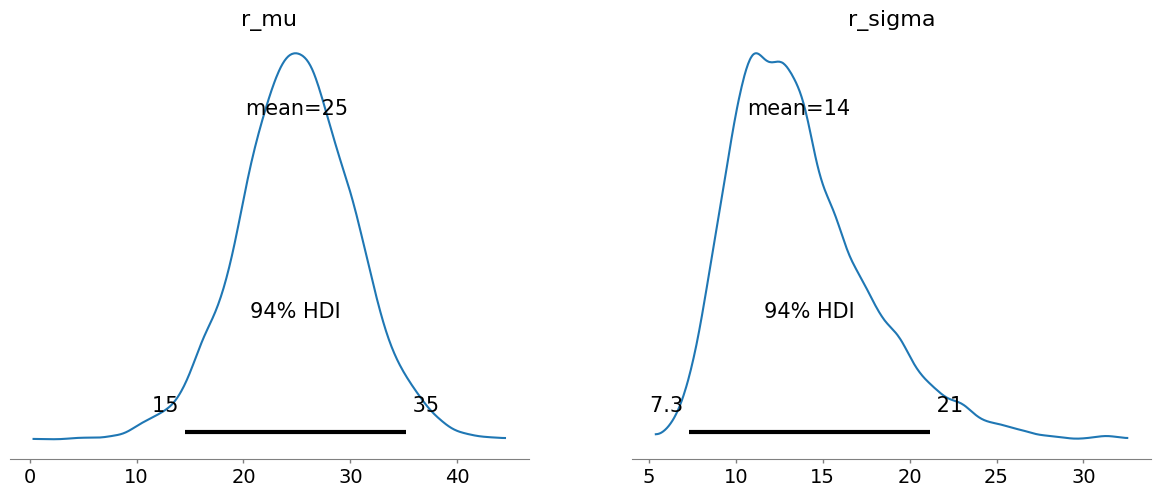

In [32]:
#Republican
with pm.Model() as r_model:
  #loose prior around 25
  mu = pm.Normal('r_mu',mu =25,sigma =10)
  sigma = pm.HalfNormal('r_sigma',sigma =10)
  observed = pm.Normal('r_observed',mu = mu,sigma =sigma,observed = republicans,shape = len(republicans))
  trace_r = pm.sample(2000,tune = 1000, return_inferencedata= True, random_seed=123)
az.plot_posterior(trace_r)

Output()

ERROR:pymc.stats.convergence:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'i_mu'}>,
       <Axes: title={'center': 'i_sigma'}>], dtype=object)

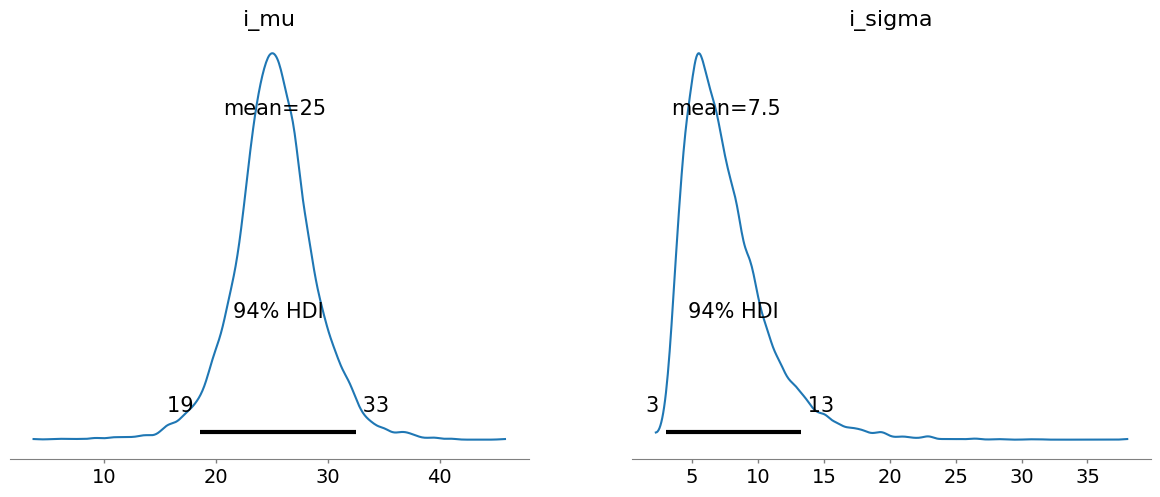

In [33]:
#Independents
with pm.Model() as i_model:

  mu = pm.Normal('i_mu',mu =25,sigma =10)
  sigma = pm.HalfNormal('i_sigma',sigma =10)
  observed = pm.Normal('i_observed',mu = mu,sigma =sigma,observed = independents,shape = len(independents))
  trace_i = pm.sample(2000,tune = 1000, return_inferencedata= True, random_seed=123)
az.plot_posterior(trace_i)

In [34]:
# Extract the posterior means
d_mean = trace_d.posterior['d_mu'].mean().item()
i_mean = trace_i.posterior['i_mu'].mean().item()
r_mean = trace_r.posterior['r_mu'].mean().item()

print(f"Democrats Posterior Mean: {d_mean:.2f}%")
print(f"Independents Posterior Mean: {i_mean:.2f}%")
print(f"Republicans Posterior Mean: {r_mean:.2f}%")

Democrats Posterior Mean: 24.99%
Independents Posterior Mean: 25.26%
Republicans Posterior Mean: 24.98%


### 2.2 Results
We used separate normal models to individually estimate the mean level of support for military aid to Ukraine among Democrats, Independents, and Republicans.The posterior mean  were 24.99% for Democrats, 25.26% for Independents, and 24.98% for Republicans. The resuslts show that Independents had a higher support that compares to other parties. Sampling was performed using PyMC’s NUTS algorithm.

# 3.Grouped Model


### 3.1 Method

*   All group data were pooled together and modeled using a single normal distribution.

* Priors and sampling methods matched those of the separate models.

In [35]:
 all_grouped_data= np.concatenate([democrats, independents, republicans])

In [36]:
all_grouped_data

array([35, 39, 16, 10, 19, 23, 26, 33, 10, 24, 21, 45])

Output()

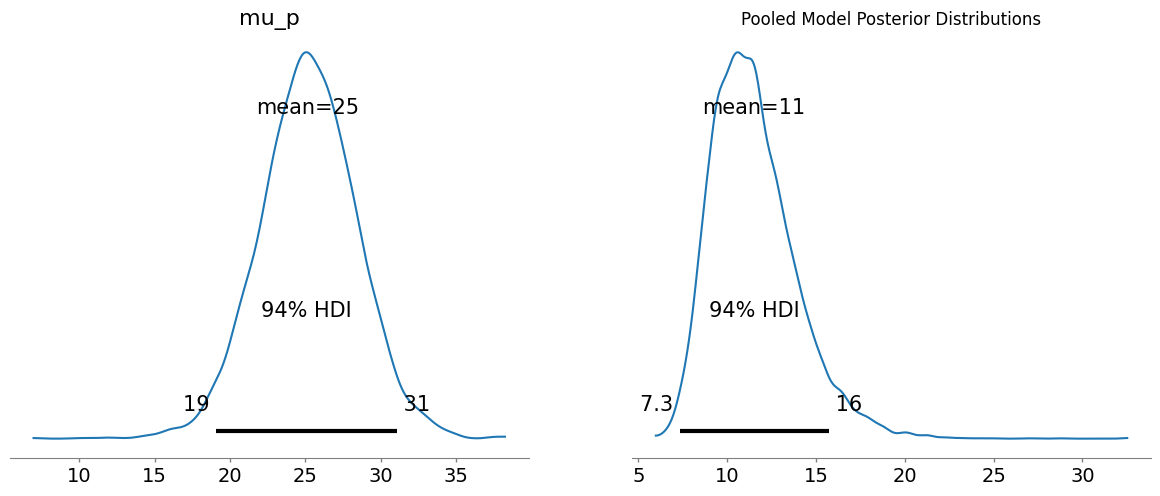

In [37]:
with pm.Model() as pooled_model:
    mu_pooled = pm.Normal('mu_p', mu=25, sigma=10)
    sigma_pooled = pm.HalfNormal('sigma_p', sigma=10)
    obs_pooled = pm.Normal('obs_p', mu=mu_pooled, sigma=sigma_pooled, observed=all_grouped_data)
    trace_pooled = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=123)

# Plot the posterior
az.plot_posterior(trace_pooled, var_names=['mu_p', 'sigma_p'])
plt.title('Pooled Model Posterior Distributions')
plt.show()

In [38]:
pooled_mean = trace_pooled.posterior['mu_p'].mean().item()

print(f"Pooled Posterior Mean: {pooled_mean:.2f}%")

Pooled Posterior Mean: 25.18%


## 3.2 Results
We used a pooled normal model to estimate a single mean level of support for military aid to Ukraine, combining data from Democrats, Independents, and Republicans. The posterior mean support estimate was 25.18%.


# 4 .Hierarchical Normal Model & Gibbs Sampling

## 4.1 Method
After separately modeling each political group and pooling all responses together, we will implement a hierarchical normal model to better balance the model need to capture group-specific differences while borrowing means and variance across the groups. We will use  Gibbs Sampling to estimate the model parameters, alternating conditional draws for group means, the population mean, and variances.

In [60]:
democrats = np.array([35, 39, 16, 10])
independents = np.array([19, 23, 26, 33])
republicans = np.array([10, 24, 21, 45])

groups = [democrats, independents, republicans]

In [61]:
n_groups = len(groups)
n_samples = [len(g) for g in groups]

In [62]:
#priors for means
mu0_m = 25
mu0_s = 10

In [63]:
# Priors for variances
a_obs = 2
b_obs = 2
a_grp = 2
b_grp = 2

In [64]:
n_iter = 5000  # Number of Gibbs iterations


mu_js = np.zeros((n_iter, n_groups))
mu0s = np.zeros(n_iter)
obs_vars = np.zeros(n_iter)
group_vars = np.zeros(n_iter)

mu_j = np.array([np.mean(g) for g in groups])
mu0 = np.mean(mu_j)
obs_var = np.var(np.concatenate(groups))
group_var = np.var(mu_j)


In [65]:
for i in range(n_iter):
    # 1. Sample each group mean mu_j
    for j in range(n_groups):
        nj = n_samples[j]
        yj_bar = np.mean(groups[j])

        mu_j_var = 1 / (nj / obs_var + 1 / group_var)
        mu_j_mean = mu_j_var * (nj * yj_bar / obs_var + mu0 / group_var)

        mu_j[j] = np.random.normal(mu_j_mean, np.sqrt(mu_j_var))

    # 2. Sample population mean mu0
    mu0_var = 1 / (n_groups / group_var + 1 / mu0_s**2)
    mu0_mean = mu0_var * (np.sum(mu_j) / group_var + mu0_m / mu0_s**2)

    mu0 = np.random.normal(mu0_mean, np.sqrt(mu0_var))

    # 3. Sample common variance
    alpha_post = a_obs + sum(n_samples) / 2
    beta_post = b_obs + 0.5 * sum([
        np.sum((groups[j] - mu_j[j])**2) for j in range(n_groups)
    ])

    obs_var = invgamma.rvs(a=alpha_post, scale=beta_post)

    # 4. Sample group variance
    alpha_post_grp = a_grp + n_groups / 2
    beta_post_grp = b_grp + 0.5 * np.sum((mu_j - mu0)**2)

    group_var = invgamma.rvs(a=alpha_post_grp, scale=beta_post_grp)

    mu_js[i, :] = mu_j
    mu0s[i] = mu0
    obs_vars[i] = obs_var
    group_vars[i] = group_var


Gibbs Sampling Loop we first update the best guess for each group's true mean, using both the group's data and how close it is to the overall average.
Then, we update the overall population mean by averaging the group means.
After that, we update how spread out individual survey answers are (observation variance), and finally how different the group means are from each other (group variance).

This process repeats thousands of times, allowing the model to gradually learn the true averages and variances by balancing the group information and overall trends.



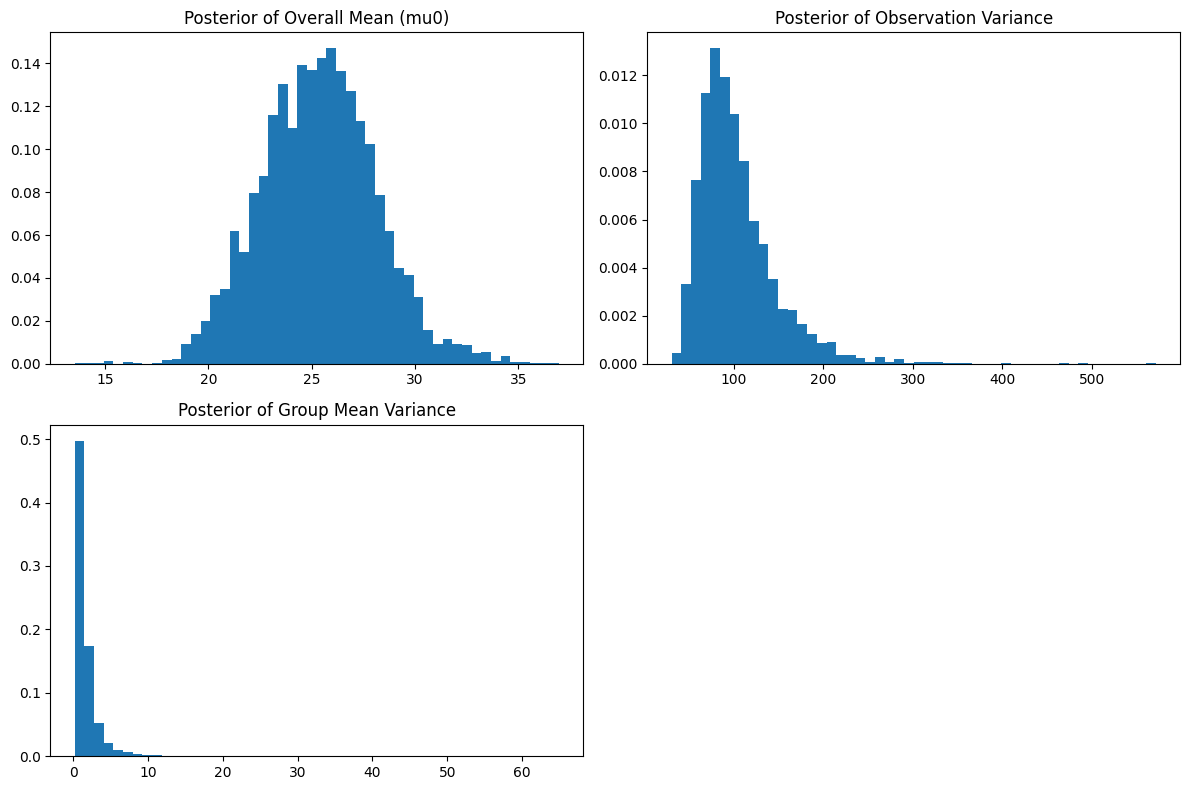

In [66]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.hist(mu0s, bins=50, density=True)
plt.title('Posterior of Overall Mean (mu0)')
plt.subplot(2,2,2)
plt.hist(obs_vars, bins=50, density=True)
plt.title('Posterior of Observation Variance')
plt.subplot(2,2,3)
plt.hist(group_vars, bins=50, density=True)
plt.title('Posterior of Group Mean Variance')
plt.tight_layout()
plt.show()


In [67]:
group_labels = ['Democrats', 'Independents', 'Republicans']

for j in range(n_groups):
    group_mean = mu_js[:, j].mean()
    print(f"{group_labels[j]} Posterior Mean: {group_mean:.2f}%")

print(f"Overall Population Mean (mu0) Posterior Mean: {mu0s.mean():.2f}%")

Democrats Posterior Mean: 25.33%
Independents Posterior Mean: 25.37%
Republicans Posterior Mean: 25.34%
Overall Population Mean (mu0) Posterior Mean: 25.35%


We used a hierarchical normal model to estimate group-specific support levels for military aid to Ukraine, while also allowing for partial pooling across political groups. In this model, each group’s mean support was assumed to come from a shared population distribution with its own hyperparameters.The posterior mean support estimates were 25.33% for Democrats, 25.37% for Independents, and 25.34% for Republicans. The estimated overall population mean (mu0) was 25.35%